### Importing the Libraries

In [1]:
# %%time
# Import the libraries
import pandas as pd
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import shutil

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras import layers
from keras import models
from os import rename, listdir
import os, zipfile
import random
from random import random
from random import randrange
from random import choice
from random import uniform
from matplotlib import pyplot
import skimage.io as io

from keras.metrics import categorical_accuracy
from keras.optimizers import Adam

import tensorflow as tf 

C:\Users\bella\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# import tensorflow as tf 

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

#### Verify that the GPU is available to work with Tensorflow

In [3]:
# %%time
print('TensorFlow was built with CUDA (GPU): ' + str(tf.test.is_built_with_cuda()))
print('TensorFlow can access a GPU: ' + str(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)))
print('GPU Available: '+ str(K.tensorflow_backend._get_available_gpus()))

TensorFlow was built with CUDA (GPU): False
TensorFlow can access a GPU: False
GPU Available: []


#### Seting the data directories

In [42]:
#Seting the directory for the images 
dir_zip = r'D:\Python\Jupyter\DeepLearning\ProjectResnet\zipFiles'
dir_database = r'D:\Python\Jupyter\DeepLearning\ProjectResnet\DataBase'
dir_MetaData = r'D:\Python\Jupyter\DeepLearning\ProjectResnet\metaData_dataBase'
dir_project = r'D:\Python\Jupyter\DeepLearning\ProjectResnet'

#### Unziping all the images

In [5]:
# %%time
extension = ".zip"

os.chdir(dir_zip) # change directory from working dir to dir with files

if len(os.listdir(os.path.abspath(dir_database)))==0 or len(os.listdir(os.path.abspath(dir_database)))==1:
    # Loop to extract all Images from a the zip file on directory
    for item in os.listdir(dir_zip): # loop through items in dir
        if item.endswith(extension): # check for ".zip" extension
            file_name = os.path.abspath(item) # get full path of files
            print("Processing %s" % file_name)
            zip_ref = zipfile.ZipFile(file_name) # create zipfile object
            os.chdir(dir_zip) # change directory from working dir to dir with files
            zip_ref.extractall(dir_database) # extract file to dir
            zip_ref.close() # close file
            #os.remove(file_name) # delete zipped file
else:
    print(len(os.listdir(os.path.abspath(dir_database))))

Processing C:\Users\bella\OneDrive\Desktop\Nova_2year\Deep_Learning\project\zipFiles\HAM10000_images_part_1.zip
Processing C:\Users\bella\OneDrive\Desktop\Nova_2year\Deep_Learning\project\zipFiles\HAM10000_images_part_2.zip


Function to undersample dataset to test faster the modifications

In [ ]:
# %%time

# from random import sample

# os.chdir(dir_database)
# if len(os.listdir(os.path.abspath(dir_database)))>500:
#     files = os.listdir(dir_database)
#     # print(files[0])
#     # print(len(files))
#     for file in sample(files,8015):
#         os.remove(file)

### Reading Metadata File

In [6]:
# %%time
#import metadata as panda dataframe
#first row is the name of the columns
#second column is the id of the images, lesions have more than one image

metadata = pd.read_csv(dir_MetaData+'/HAM10000_metadata.csv', header=0, index_col=1)

In [7]:
# Create a list of file names
#-------------------------------------------------#
filenames = [os.path.splitext(filename)[0] for filename in os.listdir(dir_database) if filename.endswith(".jpg")]
prov_filenames = []
for name in filenames:
    prov_filenames.append(name[-12:])
filenames = prov_filenames
filenames = pd.DataFrame(np.array(filenames).reshape(10015,1),columns=['filenames'])
# filenames = pd.DataFrame(np.array(filenames).reshape(2000,1),columns=['filenames'])

In [8]:
# # Organize dataset according to photos actual order
# ----------------------------------------------------
# # Merging the file names and the metadata, thus organizing the data.

organized_metadata = pd.merge(left=filenames, right=metadata, left_on='filenames',right_on='image_id')
# # print(organized_metadata)

In [9]:
# It removes all metadata but dx (lesion type)
organized_metadata['filenames_dx'] = organized_metadata['dx'] + '.' + organized_metadata['filenames']

In [10]:
# Save Metadata on Database Directoy
os.chdir(dir_database)
organized_metadata.to_csv('organized_metadata.csv', sep=',', index = False)

In [11]:
# %%time
# # Labels
# Verify whether it is useful or not
labels = np.array(organized_metadata['dx'].tolist())
filenames_dx = np.array(organized_metadata['filenames_dx'].tolist())
print(len(labels))

10015


In [12]:
# Creating Train / Val / Test folders (One time use)
lesionstype = ['nv','mel',"vasc",'akiec','bcc','bkl','df']

In [13]:
os.chdir(dir_database)

In [14]:
# %%time
def list_files(path):
    # returns a list of names (with extension, without full path) of all files 
    # in folder path
    files = []
    for name in os.listdir(path):
        if os.path.isfile(os.path.join(path, name)):
            files.append(name)
    return files 

images = list_files('.')

for img, extra in zip(images, labels) :
    filename, extension = os.path.splitext(img)
    if filename.startswith("ISIC_"):
        os.rename(img, ''.join([extra, '-', filename, extension]))
#     print(img)

In [15]:
# Listintg the file names again (After the modify them):

def get_file_list_from_dir(dir_database):
    all_files = os.listdir(os.path.abspath(dir_database))
    data_files = list(filter(lambda file: file.endswith(".jpg"), all_files))
    return data_files

filenames = get_file_list_from_dir(dir_database)

In [16]:
# Shuffle the data order:
import random
random.shuffle(filenames)

In [17]:
print(len(filenames))
print(len(labels))

10015
10015


### Spliting Train, Validate and Test Set

In [18]:
data_train, data_validate, label_train, label_validate = train_test_split(np.array(filenames), labels, 
                                                                          test_size=0.4, 
                                                                          random_state=1, 
                                                                          stratify=labels)

data_validate, data_test, label_validate, label_test = train_test_split(data_validate, label_validate, 
                                                                  test_size=0.5, 
                                                                  random_state=1, 
                                                                  stratify=label_validate)

train_filenames = [name for name in data_train.tolist()]
val_filenames = [name for name in data_validate.tolist()]
test_filenames = [name for name in data_test.tolist()]

In [19]:
print('Total images: ', len(filenames))
print('Training: ', len(train_filenames))
print('Validation: ', len(val_filenames))
print('Testing: ', len(test_filenames))

Total images:  10015
Training:  6009
Validation:  2003
Testing:  2003


In [20]:
print('Total labels: ', len(labels))
print('Training_labels: ', len(label_train))
print('Validation_labels: ', len(label_validate))
print('Testing_labels: ', len(label_test))

Total labels:  10015
Training_labels:  6009
Validation_labels:  2003
Testing_labels:  2003


In [21]:
unique_elements, counts_elements = np.unique(label_train, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
 ['196' '309' '659' '69' '668' '4023' '85']]


In [22]:
os.chdir(dir_database)

Spliting Images into Train / Validate / Test Directories

In [23]:
# %%time
# # Copy-pasting images: for train, validation and test

envs = dict()
envs['train'] = train_filenames
envs['test'] = test_filenames
envs['val'] = val_filenames

for env in envs:
    if not os.path.isdir(dir_database +'/'+ env): os.makedirs(dir_database +'/'+ env)
    for i in lesionstype:   
        print('Analysing '+ env + ' ' + i + ' Lesions')
        if not os.path.isdir(dir_database + '/'+env+'/' + i): os.makedirs(dir_database + '/'+env+'/' + i)
        if len(os.listdir(os.path.abspath(dir_database + '/'+env+'/' + i)))<=1:
            for name in envs[env]:
                if name.startswith(i):
                    shutil.copy(name, dir_database+"/"+env+"/"+i+"/")
        print(env+' '+i+' lesions images: '+ str(len(os.listdir(os.path.abspath(dir_database + '/'+env+'/' + i)))))
    print()
    print('---- / / ----')


Analysing train nv Lesions
train nv lesions images: 4032
Analysing train mel Lesions
train mel lesions images: 680
Analysing train vasc Lesions
train vasc lesions images: 85
Analysing train akiec Lesions
train akiec lesions images: 186
Analysing train bcc Lesions
train bcc lesions images: 305
Analysing train bkl Lesions
train bkl lesions images: 654
Analysing train df Lesions
train df lesions images: 67

---- / / ----
Analysing test nv Lesions
test nv lesions images: 1310
Analysing test mel Lesions
test mel lesions images: 249
Analysing test vasc Lesions
test vasc lesions images: 28
Analysing test akiec Lesions
test akiec lesions images: 64
Analysing test bcc Lesions
test bcc lesions images: 110
Analysing test bkl Lesions
test bkl lesions images: 217
Analysing test df Lesions
test df lesions images: 25

---- / / ----
Analysing val nv Lesions
val nv lesions images: 1363
Analysing val mel Lesions
val mel lesions images: 184
Analysing val vasc Lesions
val vasc lesions images: 29
Analysing

The paths for the training and validation images

In [24]:
train_path = dir_database+"/train"
val_path = dir_database+"/val"
test_path = dir_database+"/test"

## NO Oversampling in this case


In [25]:
# Declare a few useful values
num_train_samples = sum([len(files) for r, d, files in os.walk(train_path)]) #len(train_filenames) 
num_val_samples = sum([len(files) for r, d, files in os.walk(val_path)]) #len(val_filenames)
num_test_samples = sum([len(files) for r, d, files in os.walk(test_path)]) #len(test_filenames)
train_batch_size = 10
val_batch_size = 10
test_batch_size = 1

image_width = 200
image_height = 150

In [26]:
datagen = ImageDataGenerator(rescale = 1./255)

In [27]:
# Declare how many steps are needed in an iteration
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)
test_steps = np.ceil(num_test_samples / val_batch_size)

### Set Up the generator batches

#### Train Batches

In [28]:
# Set up generators
print('Train Batches: ')
train_batches = datagen.flow_from_directory(
    train_path,
    target_size=(image_height, image_width),
    batch_size=train_batch_size,
    class_mode = 'categorical',
    classes = lesionstype)

Train Batches: 
Found 6009 images belonging to 7 classes.


#### Validation Batches

In [29]:
val_batches = datagen.flow_from_directory(
    val_path,
    target_size=(image_height, image_width),
    batch_size=val_batch_size,
    class_mode = 'categorical',
    classes = lesionstype)

Found 2003 images belonging to 7 classes.


#### Test Batches

In [30]:
test_batches = datagen.flow_from_directory(
    test_path,
    target_size=(image_height, image_width),
    batch_size=test_batch_size,
    class_mode = 'categorical',
    classes = lesionstype)

Found 2003 images belonging to 7 classes.


In [31]:
for data_batch, labels_batch in train_batches:
    print('Train: data batch shape:', data_batch.shape)
    print('Train: labels batch shape:', labels_batch.shape)
    print('--//--')
    break
    
for data_batch, labels_batch in val_batches:
    print('Validation: data batch shape:', data_batch.shape)
    print('Validation: labels batch shape:', labels_batch.shape)
    print('--//--')
    break
    
for data_batch, labels_batch in test_batches:
    print('Test: data batch shape:', data_batch.shape)
    print('Test: labels batch shape:', labels_batch.shape)
    print('--//--')
    break

Train: data batch shape: (10, 150, 200, 3)
Train: labels batch shape: (10, 7)
--//--
Validation: data batch shape: (10, 150, 200, 3)
Validation: labels batch shape: (10, 7)
--//--
Test: data batch shape: (1, 150, 200, 3)
Test: labels batch shape: (1, 7)
--//--


### Custom Metrics

In [39]:
def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    """Computes the F score.
    The F score is the weighted harmonic mean of precision and recall.
    Here it is only computed as a batch-wise average, not globally.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.

    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    """

    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    """Computes the f-measure, the harmonic mean of precision and recall.
    Here it is only computed as a batch-wise average, not globally.
    """
    return fbeta_score(y_true, y_pred, beta=1)

### Class Weight

In [40]:
# Add weights to make the model more sensitive to melanoma
class_weights={
    0: 1.0,  # akiec
    1: 1.0,  # bcc
    2: 1.0,  # bkl
    3: 1.0,  # df
    4: 1.0,  # mel
    5: 1.0,  # nv
    6: 1.0,  # vasc
}

## Checkpoint / Learning Rate / Callback 

In [43]:
# Declare the filepath for the saved model
os.chdir(dir_project)
filepath = "model.h5"

# Declare a checkpoint to save the best version of the model
checkpoint = ModelCheckpoint(filepath, monitor='categorical_accuracy', verbose=1,
                             save_best_only=True, mode='max')

# Reduce the learning rate as the learning stagnates
reduce_lr = ReduceLROnPlateau(monitor='categorical_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=1E-8)

callbacks_list = [checkpoint, reduce_lr]
# callbacks_list = [checkpoint]

# Transfer Learning

In [32]:
#using 
# https://arxiv.org/abs/1512.00567
# https://towardsdatascience.com/how-to-train-your-model-dramatically-faster-9ad063f0f718
from keras.applications import InceptionV3
from keras.models import Model

original_model    = InceptionV3()
bottleneck_input  = original_model.get_layer(index=0).input
bottleneck_output = original_model.get_layer(index=-2).output
bottleneck_model  = Model(inputs=bottleneck_input, outputs=bottleneck_output)

96116736/96112376 [==============================] - 82s 1us/step


In [34]:
print(bottleneck_model.get_layer(index=0).input) #some indeterminate amount of images as input, of an unspecified height and width, with 3 RBG channels

Tensor("input_1:0", shape=(?, ?, ?, 3), dtype=float32)


In [37]:
print(bottleneck_model.get_layer(index=-2).output)

Tensor("mixed10/concat:0", shape=(?, ?, ?, 2048), dtype=float32)


In [36]:
#freeze
for layer in bottleneck_model.layers:
    layer.trainable = False

In [52]:
new_model = Sequential()
new_model.add(bottleneck_model)

#max3/4 layers
#new_model.add(layers.Dense(512, activation='relu',input_dim=2048))
new_model.add(layers.Dense(128, activation='relu',input_dim=2048))
new_model.add(layers.Dense(52, activation='relu'))
new_model.add(layers.Dense(7, activation='softmax'))

In [53]:
new_model.summary() #the first part is freezed

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 2048)              21802784  
_________________________________________________________________
dense_5 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_6 (Dense)              (None, 52)                6708      
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 371       
Total params: 22,072,135
Trainable params: 269,351
Non-trainable params: 21,802,784
_________________________________________________________________


In [54]:
new_model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=[categorical_accuracy])

In [55]:
history = new_model.fit_generator(train_batches,
                              steps_per_epoch=train_steps,
                              class_weight=class_weights,
                              validation_data=val_batches,
                              validation_steps=val_steps,
                              epochs=15,
                              verbose=1,
                              callbacks=callbacks_list)

Epoch 1/15
601/601 [==============================] - 870s 1s/step - loss: 5.1837 - categorical_accuracy: 0.6769 - val_loss: 5.1098 - val_categorical_accuracy: 0.6830

Epoch 00001: categorical_accuracy improved from -inf to 0.67698, saving model to model.h5
Epoch 2/15
601/601 [==============================] - 843s 1s/step - loss: 5.3241 - categorical_accuracy: 0.6697 - val_loss: 5.2144 - val_categorical_accuracy: 0.6765

Epoch 00002: categorical_accuracy did not improve from 0.67698
Epoch 3/15
601/601 [==============================] - 772s 1s/step - loss: 5.4094 - categorical_accuracy: 0.6644 - val_loss: 5.2064 - val_categorical_accuracy: 0.6770

Epoch 00003: categorical_accuracy did not improve from 0.67698

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 4/15
601/601 [==============================] - 747s 1s/step - loss: 5.2121 - categorical_accuracy: 0.6766 - val_loss: 5.1501 - val_categorical_accuracy: 0.6805

Epoch 00004: categorical_accurac

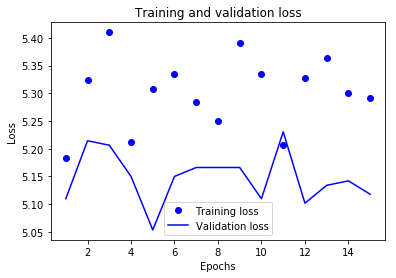

In [56]:
# Plotting the evolution of the loss, comparing training and validation
# To check if the number of epochs are not set properly

import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

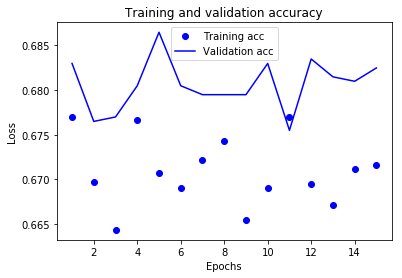

In [57]:
# Plotting the evolution of the metrics, comparing training and validation
# To check if the number of epochs are not set properly

plt.clf()      # clears the figure
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [58]:
## Evaluation of the model with metrics and confusion matrix ##

# Declare a function for plotting the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [60]:
### Training evaluation : Confusion matrix and metrics  ###

# Create a confusion matrix of the training images
train_labels = train_batches.classes

# Make predictions
predictions = new_model.predict_generator(train_batches, steps=train_steps ,verbose=1)#, steps=train_steps

601/601 [==============================] - 431s 717ms/step


In [61]:
print(set(train_labels))
print(predictions)

{0, 1, 2, 3, 4, 5, 6}
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [62]:
train_batches

In [63]:
predictions.shape

(6009, 7)

In [64]:
cm = confusion_matrix(train_labels, predictions.argmax(axis=1))
cm

array([[4032,    0,    0,    0,    0,    0,    0],
       [ 680,    0,    0,    0,    0,    0,    0],
       [  85,    0,    0,    0,    0,    0,    0],
       [ 186,    0,    0,    0,    0,    0,    0],
       [ 305,    0,    0,    0,    0,    0,    0],
       [ 654,    0,    0,    0,    0,    0,    0],
       [  67,    0,    0,    0,    0,    0,    0]], dtype=int64)

Confusion matrix, without normalization
[[4032    0    0    0    0    0    0]
 [ 680    0    0    0    0    0    0]
 [  85    0    0    0    0    0    0]
 [ 186    0    0    0    0    0    0]
 [ 305    0    0    0    0    0    0]
 [ 654    0    0    0    0    0    0]
 [  67    0    0    0    0    0    0]]


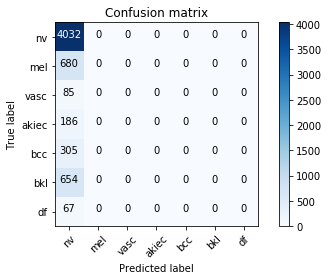

In [65]:
#cm = confusion_matrix(train_labels, predictions.argmax(axis=1))
plot_confusion_matrix(cm, lesionstype)

201/201 [==============================] - 139s 691ms/step
Confusion matrix, without normalization
[[1363    0    0    0    0    0    0]
 [ 184    0    0    0    0    0    0]
 [  29    0    0    0    0    0    0]
 [  77    0    0    0    0    0    0]
 [  99    0    0    0    0    0    0]
 [ 228    0    0    0    0    0    0]
 [  23    0    0    0    0    0    0]]


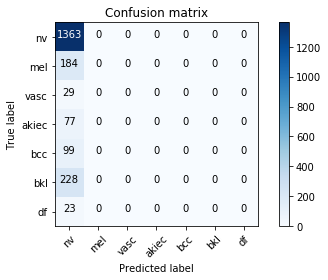

In [67]:
### Validation evaluation : Confusion matrix and metrics ###

# Create a confusion matrix of the training images
val_labels = val_batches.classes

# Make predictions
predictions = new_model.predict_generator(val_batches, steps=val_steps, verbose=1)
cm = confusion_matrix(val_labels, predictions.argmax(axis=1))
cm_plot_labels = lesionstype
plot_confusion_matrix(cm, cm_plot_labels)

2003/2003 [==============================] - 180s 90ms/step
Confusion matrix, without normalization
[[1310    0    0    0    0    0    0]
 [ 249    0    0    0    0    0    0]
 [  28    0    0    0    0    0    0]
 [  64    0    0    0    0    0    0]
 [ 110    0    0    0    0    0    0]
 [ 217    0    0    0    0    0    0]
 [  25    0    0    0    0    0    0]]


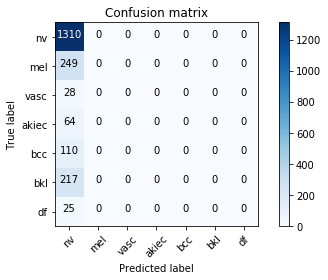

In [68]:
### Test evaluation : Confusion matrix and metrics ###

# Create a confusion matrix of the test images
test_labels = test_batches.classes

# Make predictions
predictions = new_model.predict_generator(test_batches, steps=num_test_samples, verbose=1)
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
cm_plot_labels = lesionstype
plot_confusion_matrix(cm, cm_plot_labels)

# OTHERS pre-trained

In [ ]:
#other pre-trained nn
#https://towardsdatascience.com/the-4-convolutional-neural-network-models-that-can-classify-your-fashion-images-9fe7f3e5399d

In [ ]:
# https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751
#instead of NN, the last part can be another model such as SVM

In [ ]:
#https://www.analyticsvidhya.com/blog/2018/07/top-10-pretrained-models-get-started-deep-learning-part-1-computer-vision/
#pre-trained most common nn by the type of problem